# Captcha predictor

Nikita Babich
ITMO University
@spacexer


# Sources to analyze
- https://habr.com/ru/companies/wunderfund/articles/331310/
- https://habr.com/ru/articles/720614/
- https://neurohive.io/ru/tutorial/primer-vzloma-prostoj-kapchi-za-15-minut-s-pomoshhju-mashinnogo-obuchenija/
- https://habr.com/ru/companies/mvideo/articles/780774/
- https://habr.com/ru/companies/skillfactory/articles/525214/
- https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/
- https://habr.com/ru/articles/464337/
- https://github.com/artempelevin/simple_captcha_solver

In [1]:
import albumentations
import numpy as np
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F

from PIL import Image

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings

In [2]:
DIR = "dataset"
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
DEVICE = "cuda"
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = {
    "paths": paths,
    "labels": labels
}

Идея в том, чтобы на имеющемся наборе картинок с каггла, где в названии лежит ответ на неё (10000 картинок) построить датасет для тренировки и теста, после чего пользоваться моделью для предсказания уже без обновления весов.

# Модель

Использую двухслойную свёрточную нейронку с рекурсией GRU
Для функции потерь использую встроенную CTCLoss

In [4]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [5]:
class Captcha_model(nn.Module):
    """
    Using pytorch nn class to create model

    2 layers CNN
    1 RNN layer
    1 GRU layer

    forward method 

    """
    def __init__(self, num_chars):
        super(Captcha_model, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)


    def forward(self, images, targets=None):
        bs, channel, height, width = images.size()

        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss

        return x, None

Построю функции для тренировки и вычисления

In [6]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

# Интеграция картинок

Изначальная задумка была в том, чтобы использовать зашумленные линиями капчи, но все фильтры, которые пытался использовать (как в источнике на гите) не работали в сочетании с моделью, поэтому отказался от них - использую просто размытые, разноцветные капчи из букв и цифр

In [7]:
def encode_targets():
    image_files = glob.glob(os.path.join(DIR, "*.jpg"))
    targets_orig = [x.split("\\")[-1].split(".")[0] for x in image_files]
    targets = [[c for c in x] for x in targets_orig]
    targets_flat = [c for clist in targets for c in clist]

    # Encode images
    lbl_enc = LabelEncoder()
    lbl_enc.fit(targets_flat)

    targets_enc = [lbl_enc.transform(x) for x in targets]
    targets_enc = np.array(targets_enc) + 1 # remove 0 index

    return image_files, targets_enc, targets_orig, lbl_enc

In [8]:
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

Рома подсказал мне, что удобно пользоваться встроенным в торч дата лоадером

In [9]:
class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [10]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False
)

In [11]:
# Load the models
model = Captcha_model(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop"
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

In [13]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

## Запуск модели с заданными параметрами и функцией ограничения от переобучения

In [14]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

100%|██████████| 1000/1000 [00:02<00:00, 415.80it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------------------'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------------------'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------------------'),
 ('862n6P13Hi',
  '---------------------------------------------------------------------------'),
 ('RsPDymcb49',
  '---------------------------------------------------------------------------')]
Epoch: 0, train_loss: 4.284828514364031, valid_loss: 4.2524825556278225


100%|██████████| 1000/1000 [00:02<00:00, 345.73it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------------88888'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------------888888'),
 ('bmqnN0sdDX',
  '----------------------------------------------------------------------88888'),
 ('862n6P13Hi',
  '----------------------------------------------------------------------88888'),
 ('RsPDymcb49',
  '---------------------------------------------------------------------888888')]
Epoch: 1, train_loss: 4.20872234307395, valid_loss: 4.179954681873322


100%|██████████| 1000/1000 [00:02<00:00, 419.29it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------------------'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------------------'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------------------'),
 ('862n6P13Hi',
  '---------------------------------------------------------------------------'),
 ('RsPDymcb49',
  '---------------------------------------------------------------------------')]
Epoch: 2, train_loss: 4.185563576671813, valid_loss: 4.169219618082047


100%|██████████| 1000/1000 [00:02<00:00, 427.72it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------4---------9'),
 ('LxB8Hdx83P',
  '--------------------------------------------------------------------------1'),
 ('bmqnN0sdDX',
  '--------------------------------------------------------------------------9'),
 ('862n6P13Hi',
  '--------------------------------------------------------------------------1'),
 ('RsPDymcb49',
  '--------------------------------------------------------------------------9')]
Epoch: 3, train_loss: 4.17239635599984, valid_loss: 4.159226780414581


100%|██████████| 1000/1000 [00:02<00:00, 403.88it/s]


[('9KN1224J1H',
  '-----------------------------------------------------------------M44444---1'),
 ('LxB8Hdx83P',
  '-----------------------------------------------------------------888-666611'),
 ('bmqnN0sdDX',
  '----------------------------------------------------------------80-44---444'),
 ('862n6P13Hi',
  '-----------------------------------------------------------------9966----11'),
 ('RsPDymcb49',
  '-----------------------------------------------------------------1112----44')]
Epoch: 4, train_loss: 4.089196404033237, valid_loss: 4.014995916128159


100%|██████████| 1000/1000 [00:02<00:00, 382.26it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------W4---------7'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------96---------7'),
 ('bmqnN0sdDX',
  '--------------------------------------------------------------22---K------K'),
 ('862n6P13Hi',
  '---------------------------------------------------------------94---------7'),
 ('RsPDymcb49',
  '---------------------------------------------------------------2----------4')]
Epoch: 5, train_loss: 3.967990494940016, valid_loss: 3.891113626718521


100%|██████████| 1000/1000 [00:02<00:00, 409.00it/s]


[('9KN1224J1H',
  '--------------------------------------------------------------MM----------0'),
 ('LxB8Hdx83P',
  '--------------------------------------------------------------96----------0'),
 ('bmqnN0sdDX',
  '-------------------------------------------------------------20--MM-------M'),
 ('862n6P13Hi',
  '--------------------------------------------------------------94----------0'),
 ('RsPDymcb49',
  '--------------------------------------------------------------20---------46')]
Epoch: 6, train_loss: 3.8510454553233253, valid_loss: 3.7920763394832613


100%|██████████| 1000/1000 [00:02<00:00, 369.96it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------WWNN---4--0'),
 ('LxB8Hdx83P',
  '----------------------------------------------------------------06----44--0'),
 ('bmqnN0sdDX',
  '----------------------------------------------------------------70--W-----W'),
 ('862n6P13Hi',
  '----------------------------------------------------------------94--66----0'),
 ('RsPDymcb49',
  '----------------------------------------------------------------66-------40')]
Epoch: 7, train_loss: 3.768728127029207, valid_loss: 3.6947868425846098


100%|██████████| 1000/1000 [00:02<00:00, 397.93it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------WWM-----4--7'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------24-----4---7'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------777-WM-----W'),
 ('862n6P13Hi',
  '---------------------------------------------------------------99---------7'),
 ('RsPDymcb49',
  '---------------------------------------------------------------10--------47')]
Epoch: 8, train_loss: 3.6963237960073685, valid_loss: 3.6372828340530394


100%|██████████| 1000/1000 [00:02<00:00, 406.17it/s]


[('9KN1224J1H',
  '--------------------------------------------------------------MMMM-----4--1'),
 ('LxB8Hdx83P',
  '--------------------------------------------------------------2k------4---1'),
 ('bmqnN0sdDX',
  '------------------------------------------------------------20---M--------W'),
 ('862n6P13Hi',
  '--------------------------------------------------------------96----------1'),
 ('RsPDymcb49',
  '--------------------------------------------------------------10--------441')]
Epoch: 9, train_loss: 3.647158395051956, valid_loss: 3.6116559734344484


100%|██████████| 1000/1000 [00:02<00:00, 343.41it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------WMM----4--11'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------3k-----4--11'),
 ('bmqnN0sdDX',
  '--------------------------------------------------------------207--W------X'),
 ('862n6P13Hi',
  '---------------------------------------------------------------96--66-----1'),
 ('RsPDymcb49',
  '---------------------------------------------------------------e66-------41')]
Epoch: 10, train_loss: 3.60723316166136, valid_loss: 3.5504385385513304


100%|██████████| 1000/1000 [00:02<00:00, 419.64it/s]


[('9KN1224J1H',
  '--------------------------------------------------------------K-K-----4---1'),
 ('LxB8Hdx83P',
  '--------------------------------------------------------------8V-----4----1'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------77----M----------X'),
 ('862n6P13Hi',
  '--------------------------------------------------------------96---6------8'),
 ('RsPDymcb49',
  '--------------------------------------------------------------9---4----4444')]
Epoch: 11, train_loss: 3.599982949256897, valid_loss: 3.5379915380477907


100%|██████████| 1000/1000 [00:02<00:00, 426.99it/s]


[('9KN1224J1H',
  '------------9-----K--------N------------------------4---------------------0'),
 ('LxB8Hdx83P',
  '-------------------x---------------------------------k--------------------1'),
 ('bmqnN0sdDX',
  '----------------------------------------N------------sv-------------------X'),
 ('862n6P13Hi',
  '-----------------9-------------------666----------------------------------1'),
 ('RsPDymcb49',
  '--------------------v-------------------v-----------------------44------9--')]
Epoch: 12, train_loss: 3.4797241800493666, valid_loss: 3.0687932389974595


100%|██████████| 1000/1000 [00:03<00:00, 316.45it/s]


[('9KN1224J1H',
  '-----------9-----K--------N-------3----2-----5----4---------1------1------8'),
 ('LxB8Hdx83P',
  '------------1-----x-----Z-------8-----B-------0----x-------8-----3--------0'),
 ('bmqnN0sdDX',
  '-------------0--------------------------N-----0-----s--------------0-----X-'),
 ('862n6P13Hi',
  '-----------8----66--------2----5-----6----------------3----3--H-----------3'),
 ('RsPDymcb49',
  '------------0-----s------0-------0----y-------0-----n-----0-----4---------t')]
Epoch: 13, train_loss: 2.449485083838304, valid_loss: 1.742579953789711


100%|██████████| 1000/1000 [00:02<00:00, 426.26it/s]


[('9KN1224J1H',
  '----------99-----K--------N-------1----2-----2----4--------1-------1------8'),
 ('LxB8Hdx83P',
  '------------1----x------B-------8-----H-------q----x-------8-----3--------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q--------n-----N-----0-----s------B-------0-----X-'),
 ('862n6P13Hi',
  '-----------8----66-------2-----n-----66--------p------1----3-----8--------3'),
 ('RsPDymcb49',
  '------------R-----s------P-------0----y-------m-----c-----p-----4---------t')]
Epoch: 14, train_loss: 1.5188748316367466, valid_loss: 1.0100059488117694


100%|██████████| 1000/1000 [00:02<00:00, 411.86it/s]


[('9KN1224J1H',
  '----------99----K---------N-------1---22----2----444-------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------q----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n-----N------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8----66-------2------n----66--------P-----1-----3-----H--------i'),
 ('RsPDymcb49',
  '------------R----s-------P-------D----y-------m-----c-----b----44---------0')]
Epoch: 15, train_loss: 0.82750482433786, valid_loss: 0.4677753215283155


100%|██████████| 1000/1000 [00:02<00:00, 417.36it/s]


[('9KN1224J1H',
  '----------99----K--------N-------1----2-----2----44--------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d---x-------8-----3---------E'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------h----N-------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8----66-------2------n----66--------P-----1-----3-----H--------i'),
 ('RsPDymcb49',
  '------------R----s-------P-------D----y-------m-----c-----b----4----------9')]
Epoch: 16, train_loss: 0.4678149657038351, valid_loss: 0.30125152149237694


100%|██████████| 1000/1000 [00:02<00:00, 373.00it/s]


[('9KN1224J1H',
  '----------9-----KK--------N------1----2-----2----44--------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d----x------8-----3---------E'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n-----N------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8----66-------2-----n-----66-------PP-----1----3------H--------i'),
 ('RsPDymcb49',
  '------------R----s------PP-------D----y-------m-----c-----b----44---------a')]
Epoch: 17, train_loss: 0.30586059739213023, valid_loss: 0.2492877768687904


100%|██████████| 1000/1000 [00:02<00:00, 363.24it/s]


[('9KN1224J1H',
  '----------99----K---------N------1----2-----2----44--------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d----x------8-----3---------E'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8----66-------2-----nn----66--------P-----1----33-----H--------i'),
 ('RsPDymcb49',
  '------------R----s-------P-------D----y-------m-----c-----b----44---------9')]
Epoch: 18, train_loss: 0.2070123789501894, valid_loss: 0.11468635720852763


100%|██████████| 1000/1000 [00:02<00:00, 414.59it/s]


[('9KN1224J1H',
  '----------99----K--------N-------1----2-----2----44--------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d----x------8-----3---------E'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8----66-------2------n---66---------P-----1-----3-----H--------i'),
 ('RsPDymcb49',
  '------------R----s-------P-------D----y-------m-----c-----b----44---------9')]
Epoch: 19, train_loss: 0.1458327520629391, valid_loss: 0.07264087660727091


100%|██████████| 1000/1000 [00:02<00:00, 416.66it/s]


[('9KN1224J1H',
  '---------99-----K--------NN------1----2-----2----444-------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d---x-------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8---666-------2-----n----66--------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R----s------P--------D----y-------m-----c-----b---444---------9')]
Epoch: 20, train_loss: 0.11496146364538516, valid_loss: 0.07820734891679604
Patience at 5


100%|██████████| 1000/1000 [00:02<00:00, 387.00it/s]


[('9KN1224J1H',
  '----------99----K--------N-------1----2-----2----444-------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L---xx------B-------8----H-------dd---x-------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d------D-----X--'),
 ('862n6P13Hi',
  '-----------8---666-------2-----n----66--------P------1----3-----HH--------i'),
 ('RsPDymcb49',
  '------------R----s------P--------D---y--------m-----c-----b----44---------9')]
Epoch: 21, train_loss: 0.09262294803496399, valid_loss: 0.03960266779409721


100%|██████████| 1000/1000 [00:02<00:00, 437.06it/s]


[('9KN1224J1H',
  '----------99----K--------N-------1----2-----2----444-------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8----HH-------d---xx------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8----66-------2-----n----666-------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R----s------P--------D---yy-------m-----c-----b----44---------9')]
Epoch: 22, train_loss: 0.07837214507903749, valid_loss: 0.04316873318812577
Patience at 4


100%|██████████| 1000/1000 [00:02<00:00, 400.64it/s]


[('9KN1224J1H',
  '----------99---K---------N-------1----2-----2----44--------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L---x-------B-------8----HH------dd---x-------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---ss-------d-------D---XX--'),
 ('862n6P13Hi',
  '-----------8---666-------2-----n----66--------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R----s------P--------D---y--------m-----c-----b----44---------9')]
Epoch: 23, train_loss: 0.0670805777057281, valid_loss: 0.039612285695242465
Patience at 3


100%|██████████| 1000/1000 [00:02<00:00, 397.30it/s]


[('9KN1224J1H',
  '----------99---KK--------N-------1----2-----2----444-------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L---xx------B-------8----HH------dd---X-------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---ss-------d------D-----X--'),
 ('862n6P13Hi',
  '-----------8---666-------2-----n----666-------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R----s------P--------D---y--------m-----c-----b----44---------9')]
Epoch: 24, train_loss: 0.06018494114676853, valid_loss: 0.06920655163971241
Patience at 2


100%|██████████| 1000/1000 [00:02<00:00, 377.57it/s]


[('9KN1224J1H',
  '----------99---KK--------N-------1----2-----2----44--------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L---x-------B-------8----H--------d---x-------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---ss-------d------D----X---'),
 ('862n6P13Hi',
  '-----------8---666-------2-----nn---666-------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R---ss------PP-------D---y--------m-----c-----b----44---------9')]
Epoch: 25, train_loss: 0.0558048137717738, valid_loss: 0.05131930947161163
Patience at 1


100%|██████████| 1000/1000 [00:03<00:00, 309.54it/s]


[('9KN1224J1H',
  '-----------9----K--------N-------1----2-----2----44--------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L---xx------B-------8----HH------dd---x-------8-----3---------F'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d------D----XX--'),
 ('862n6P13Hi',
  '-----------8---666-------2-----n-----66-------P------1----3-----HH--------i'),
 ('RsPDymcb49',
  '------------R----s------P--------D---y--------m-----c-----b----44---------9')]
Epoch: 26, train_loss: 0.051296529784876234, valid_loss: 0.04403090733871795
Patience at 0


100%|██████████| 1000/1000 [00:03<00:00, 322.42it/s]


[('9KN1224J1H',
  '----------99----K--------N-------1----2-----2----444-------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d---x-------8-----3---------F'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d-------D----X--'),
 ('862n6P13Hi',
  '-----------8----66-------2------n---666-------PP-----1----33-----H--------i'),
 ('RsPDymcb49',
  '------------R----s------P--------D---y--------m-----c-----b----44---------9')]
Epoch: 27, train_loss: 0.047296283092543794, valid_loss: 0.02832991945692629
Early Stopping Implemented.


In [15]:
torch.save(model.state_dict(), "model_finish")

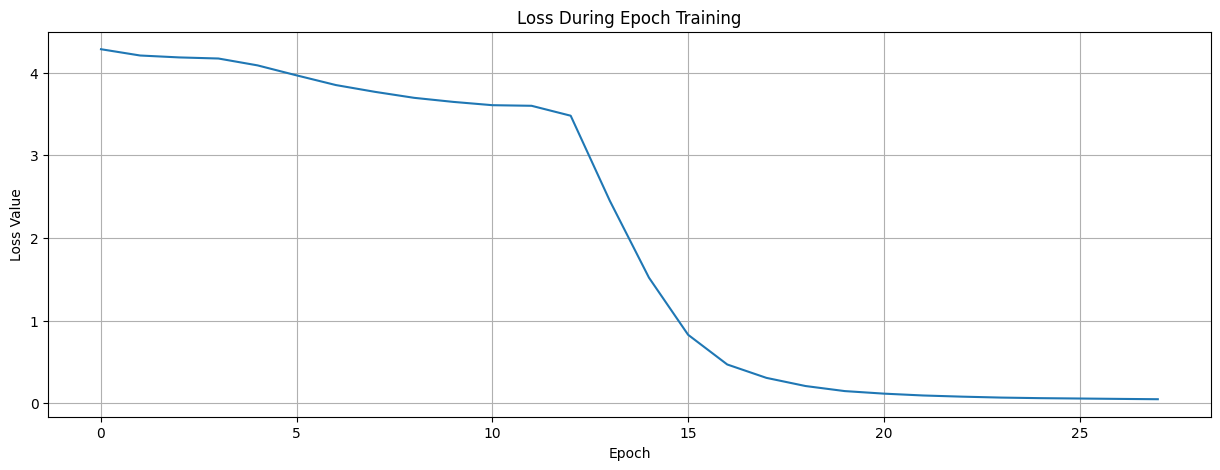

In [21]:
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
plt.plot(loss)
plt.savefig("release of loss.png")
plt.show()

# Оценка предсказаний нейросети

Проверяю, насколько точно предсказание получается на рандомном изображении

In [17]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        shuffle=False
    )
    
    return img, eval_loader

In [18]:
image_path, eval_loader = get_sample_photo()

def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
    cleaned_predictions = "".join(cleaned_predictions)
    if len(cleaned_predictions) == 10:
        return cleaned_predictions
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("\\")[-1].split(".")[0]
    plt.title(image_path[0].split("\\")[-1])
    plt.imshow(image)
    
    valid_preds, _ = eval_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])

    if preds == target:
        success = True
    else:
        success = False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

{'success': True, 'prediction': '5z149CSQOY', 'real': '5z149CSQOY'}


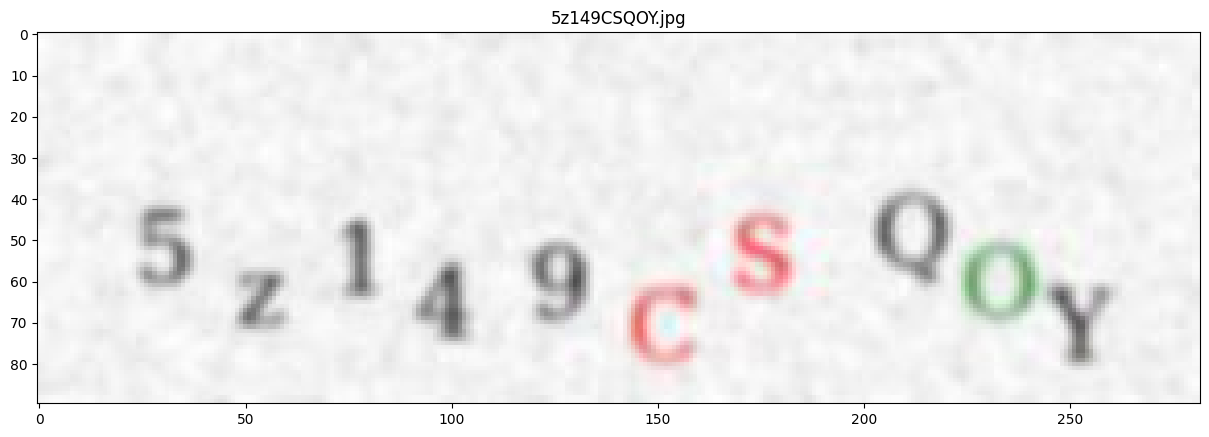

In [19]:
preds = predict_captcha(model, eval_loader, image_path)
print(preds)